### Independent Component Analysis

&nbsp;

Independent Component Analysis is an algorithm to obtain a linear combination of the original data source. So does Principal Component Analysis! Well, ICA attempts to decompose the original data into independent subsets yet PCA attempts to maximize the variance in the new linear combination. The computation of ICA is slightly more complex than PCA. ICA relies on gradient descent to find the "optimal" linear combination.

Assuming we have observed data $X$, the data is generated by the process $X=As$, where $A$ denotes the mixing matrix and $s$ denotes the original signals. Under the assumption $A$ is a square matrix and $s$ is generated by non-Gaussian process, we denote $W$ as the inverse of mixing matrix $A$. We can approximate $W$ by using gradient descent to minimize the log likelihood. Although Andrew didn't tell us when to declare the convergence of the algorithm, the percentage change of the log likelihood must be a good choice (as in Expectation Maximization algorithm).

$W:=W+\alpha [(1-\frac {2}{1+e^{-W^T X}})X^T+(W^T)^{-1}]$

There are two points on the assumptions for clarification. 

* $A$ doesn't necessarily need to be a square matrix. If A exhibits traits of more sources than mixtures, this becomes overcomplete representations in linear algebra, which can get very nasty. On the contrary, if more mixtures than sources, we can simply apply PCA to reduce mixtures then solve the problem in the form of ICA.

* $s$ must be non-Gaussian to avoid the rotational symmetry. You can check the detailed derivations in the first section of Andrew Ng's lecture notes. In this script, we follow Andrew's template, assuming data is generated by sigmoid function. If you do a search on the internet, you would realize most scripts use  hyperbolic tangent function instead. It is also the default choice of sklearn as the fixed point scheme boosts the performance of ICA. You can check the last reference for more details.  

If you are too lazy to compute the derivative of sigmoid...

https://www.wolframalpha.com/input/?i=derivative+of+log%28LogisticSigmoid%28z%29*%281-LogisticSigmoid%28z%29%29%29+with+respect+to+z

Reference on Principal Component Analysis

https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb

Reference on Gradient Descent

https://github.com/je-suis-tm/machine-learning/blob/master/gradient%20descent.ipynb
   
Alternative (very detailed) material for ICA

https://www.researchgate.net/publication/327352477_Independent_Component_Analysis_an_Introduction

Reference on how sklearn implements fast ICA

https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf


In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import sklearn.decomposition

In [2]:
#no math error is tolerated
np.seterr(divide='raise',over='raise',
          under='raise',invalid='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
#self implemented ica with sigmoid kernel
#a proper learning rate is crucial to the success of ica
def ica(X,alpha=0.001,max_itr=1000,
        tau=0.001,diagnosis=True,
        W_init=[]):

    ll_old=None
    ll_new=None
    counter=0

    #unless you really know what you are doing
    #identity matrix is a very good initial guess
    if len(W_init)==0:
        W_init=np.identity(X.shape[1])
    W=W_init   

    #batch gradient descent
    while counter<max_itr:

        #sigmoid cdf assumption
        sigmoid=np.exp(W@X.T)/(1+np.exp(W@X.T))

        #avoid singular matrix
        try:
            gradient=(1-2*sigmoid)@X+np.linalg.inv(W.T)
        except LinAlgError:
            gradient=(1-2*sigmoid)@X+np.linalg.pinv(W.T)

        #update params
        W+=alpha*gradient

        #tracking
        counter+=1
        ll_old=ll_new
        ll_new=log_likelihood(sigmoid,W)

        #convergence
        if ll_old and abs(ll_new/ll_old-1)<tau:
            if diagnosis:
                print(f'Converged after {counter} iterations.')
            return W
    
    if diagnosis:
        print(f'Not converged after {max_itr} iterations.')
    return W

In [4]:
#compute logarithm likelihood
def log_likelihood(sigmoid,W):
    
    #avoid negative value in logarithm
    if np.linalg.det(W)>=0:
        return (np.log(sigmoid.T@(1-sigmoid))+np.log(np.linalg.det(W))).sum()
    else:
        return (np.log(sigmoid.T@(1-sigmoid))).sum()

### Data Generating Process

Please check the link below

https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html

In [5]:
#sklearn used 2000 data points
#as our implementation is slower
#lets reduce it to a lower level
time=np.linspace(0,8,200)

#signal1 sinusoidal signal
#signal2 square signal
#signal3 saw tooth signal
signal1=np.sin(2*time)
signal2=np.sign(np.sin(3*time))
signal3=scipy.signal.sawtooth(2*np.pi*time)

#create matrix
signals=np.c_[signal1,signal2,signal3]

#add gaussian noise
signals+=0.2*np.random.normal(size=signals.shape)

In [6]:
#mixing matrix
A=np.array([[1,1,1],[0.5,2,1.0],[1.5,1.0,2.0]])

#mix data
X=signals@A

### Run

In [7]:
#unmix the input signal
W=ica(X)
signals_ica=X@W

Converged after 14 iterations.


In [8]:
#sklearn fast ica
clf=sklearn.decomposition.FastICA(w_init=np.eye(X.shape[1]),
                                  tol=0.001)

signals_skl=clf.fit_transform(X)

In [9]:
print(clf.mixing_)
print(W)

[[ -7.44023013  14.31134028  -9.41218143]
 [-28.721926     9.18142551 -10.61035119]
 [-14.45841577  18.6293281   -9.36033828]]
[[ 6.13535259e-01 -1.43253996e-03 -3.99644774e-01]
 [ 5.50685863e-04  1.65270758e-01 -1.63333672e-01]
 [-3.98749779e-01 -1.63370113e-01  5.14571852e-01]]


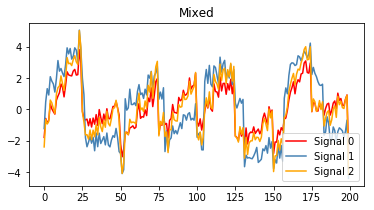

In [10]:
colors=['red','steelblue','orange']
ax=plt.figure(figsize=(6,3)).add_subplot(111)
for ind,var in enumerate(X.T):
    plt.plot(var,label=f'Signal {ind}',c=colors[ind])
plt.title('Mixed')
plt.legend()
plt.show()

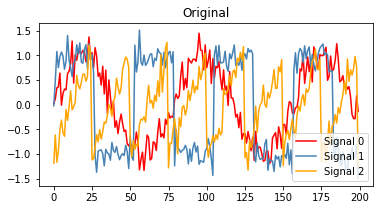

In [11]:
ax=plt.figure(figsize=(6,3)).add_subplot(111)
for ind,var in enumerate(signals.T):
    plt.plot(var,label=f'Signal {ind}',c=colors[ind])
plt.title('Original')
plt.legend()
plt.show()

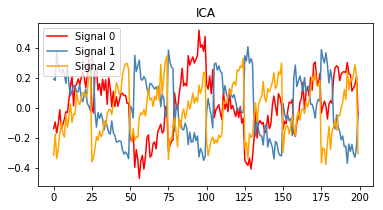

In [12]:
#the decomposition looks okay although out of scale
#unfortunately there is no way to recover the correct scaling
ax=plt.figure(figsize=(6,3)).add_subplot(111)
for ind,var in enumerate(signals_ica.T):
    plt.plot(var,label=f'Signal {ind}',c=colors[ind])
plt.title('ICA')
plt.legend()
plt.show()

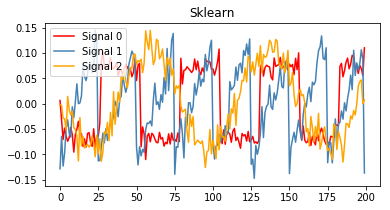

In [13]:
#even sklearn cannot revert the mixture back to the original
ax=plt.figure(figsize=(6,3)).add_subplot(111)
for ind,var in enumerate(signals_skl.T):
    plt.plot(var,label=f'Signal {ind}',c=colors[ind])
plt.title('Sklearn')
plt.legend()
plt.show()